# Impact of Transaction Costs on the Salopek Strategy

In [1]:
import numpy.typing as npt
import numpy as np
from typing import Union
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# own module
from simulations.fractional_brownian import (
    generate_brownian_path,
    generate_n_assets_portfolio,
)
from backtest.backtester import Backtester
from strategy.strategy import SalopekStrategy

from utility.utils import generate_t, a_order_power_mean, transaction_cost_L

In [18]:
N_SIMULATION = 10

ALPHA = -30
BETA = 30

# fees (no fees now)
P1 = 0  # 0.1 proportionality factor p1 (in percent)
P2 = 0  # 0.5 minimum fee p2 (in monetary units)

SCALING_FACTOR = 100  # \gamma


salopek_strat = SalopekStrategy(alpha=ALPHA, beta=BETA)
bk_tester = Backtester()

all_V_t_psi = []
all_V_t_phi = []
all_transaction_account = []

for _ in tqdm(
    range(N_SIMULATION),
    leave=False,
    desc="Computing MC simulation...",
    total=N_SIMULATION,
):
    df_ptf = generate_n_assets_portfolio(
        n_assets=2,
        n_steps=250,
        T=1,
        H=0.7,
        mu=0.05,
        sigma=0.1,
        s0=100,
        add_risk_free_asset=False,
        as_dataframe=True,
        brownian_type="fractional",
    )
    df, V_t_psi, V_t_phi, transaction_account = bk_tester.run_backtest(
        universe_dataframe=df_ptf,
        allocation_function=salopek_strat.get_allocation,
        p1=P1,
        p2=P2,
    )
    all_V_t_psi.append(V_t_psi)
    all_V_t_phi.append(V_t_phi)
    all_transaction_account.append(transaction_account)
    del df_ptf

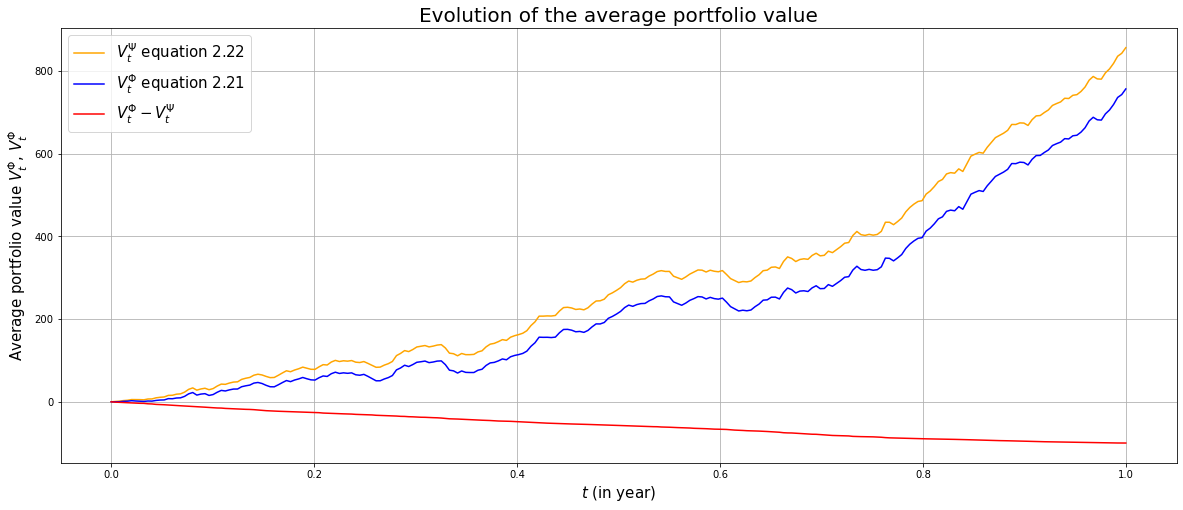

In [19]:
_, ax = plt.subplots(1, 1, figsize=(20, 8))
t = generate_t(250, 1)
ax.plot(
    t, np.mean(all_V_t_psi, axis=0), label=r"$V_t^\Psi$ equation 2.22", color="orange"
)
ax.plot(
    t,
    np.mean(all_V_t_phi, axis=0),
    # linestyle="--",
    label=r"$V_t^\Phi$ equation 2.21",
    color="blue",
)
ax.plot(
    t,
    np.mean(all_V_t_phi, axis=0) - np.mean(all_V_t_psi, axis=0),
    label=r"$V_t^\Phi-V_t^\Psi$",
    color="red",
)

ax.set_xlabel("$t$ (in year)", fontsize=15)
ax.set_ylabel(r"Average portfolio value $V_t^\Phi$, $V_t^\Phi$", fontsize=15)
ax.set_title(f"Evolution of the average portfolio value", fontsize=20)
ax.grid()
# ax_l2.legend(fontsize=15, loc="upper left")
ax.legend(fontsize=15, loc="upper left")